In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spellchecker import SpellChecker
from typing import Optional

In [2]:
from typing import List, Dict
from collections import defaultdict
from enum import Enum

from account import Account  # Assuming Account class is defined in account.py
from transaction import Transaction  # Assuming Transaction class is defined in transactions.py
from ei_finance import EiFinance


In [ ]:

def add_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        existing_df = pd.read_csv(filename)
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        combined_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    combined_df.to_csv(filename, index=False)

def save_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    new_df.to_csv(filename, index=False)

def read_expenses_from_csv(csv) -> List[Transaction]:
    df = pd.read_csv(csv)

#    for idx, row in df.iterrows():
        # You can access each row as a Series, e.g. row['name'], row['amount'], etc.
#        print(row)
    expenses = []
    for _, row in df.iterrows():
        expense = Transaction(
            name=row.get('name'),
            date=row.get('date'),
            currency=row.get('currency'),
            amount=row.get('amount'),
            account=row.get('account'),
            description=row.get('description'),
            category=row.get('category'),
            tags=row.get('tags').split(',') if isinstance(row.get('tags'), str) else [],
            recurring=row.get('recurring') in [True, 'True', 'true', 'yes', 'Yes'],
            frequency=row.get('frequency'),
            inout=row.get('inout'),
            id=row.get('id') if pd.notnull(row.get('id')) else None
        )
        expenses.append(expense)
    return expenses

def get_expenses_cost(expenses: List[Transaction]) -> float:
    """Calculate the total cost of all expenses."""
    total_cost = sum(expense.amount for expense in expenses if expense.inout == 'out')
    return total_cost
def get_expenses_income(expenses: List[Transaction]) -> float:
    """Calculate the total income from all expenses."""
    total_income = sum(expense.amount for expense in expenses if expense.inout == 'in')
    return total_income
def get_expenses_balance(expenses: List[Transaction]) -> float:
    """Calculate the balance from all expenses."""
    total_cost = get_expenses_cost(expenses)
    total_income = get_expenses_income(expenses)
    return total_income - total_cost

def draw_piechart(expenses: List[Transaction], by: str = 'category', title: Optional[str] = None):
    """
    Draw a pie chart of expenses grouped by a specified attribute.
    Args:
        expenses: List of Transaction objects.
        by: Attribute to group by ('category', 'tags', or 'account').
        title: Title for the chart. If None, a default will be used.
    """
    title = title + " " + by.capitalize() if title else None

    data = defaultdict(float)
    if by == 'tags':
        for expense in expenses:
            if expense.tags:
                for tag in expense.tags:
                    if tag:
                        data[tag.strip()] += expense.amount
    elif by == 'category':
        for expense in expenses:
            key = expense.category if expense.category else 'Uncategorized'
            data[key] += expense.amount
    elif by == 'account':
        for expense in expenses:
            key = expense.account.strip() if expense.account else 'Unknown Bank'
            data[key] += expense.amount
    else:
        for expense in expenses:
            key = getattr(expense, by, None)
            if key:
                data[key] += expense.amount

    if not data:
        print(f"No data to plot for '{by}'.")
        return

    if title is None:
        title = f"Expenses by {by.capitalize()}"

    plt.figure(figsize=(10, 6))
    plt.pie(data.values(), labels=[str(k) for k in data.keys()], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def get_expenses_banks(expenses: List[Transaction], account: str) -> List[Transaction]:
    """Print the unique banks from the expenses."""
    return [expense for expense in expenses if expense.account == account]


In [ ]:

csv = 'data/transactions.csv'
csv2 = 'data/accounts.csv'
ei_finance = EiFinance(csv, csv2)

new_expense = Transaction(
    name='Groceries',
    date='2023-01-03',
    currency='USD',
    amount=150.00,
    description='Weekly grocery shopping',
    tags=['groceries', 'food'],
    recurring=False,
    frequency=None,
    inout='out'
)

new_expense.print()
ei_finance.add_expense2expenses([new_expense])
save_expense2csv(ei_finance.expenses, csv)

print("Unique Tags:", ei_finance.tags)


Name: Groceries, Date: 2023-01-03, Currency: USD, Amount: 150.0, Bank: None, Description: Weekly grocery shopping, Category: None, Tags: groceries, food, Recurring: False, Frequency: None, In/Out: out, ID: Groceries_2023-01-03_150.0_USD
Transaction with ID Groceries_2023-01-03_150.0_USD already exists. Skipping.
Unique Tags: ['food', 'groceries', 'salary']


In [5]:
bank_expenses = get_expenses_banks(ei_finance.expenses, 'Bank of America')
for expense in bank_expenses:
    expense.print()

#draw_piechart(ei_finance.expenses, 'account', 'Expenses by')
#draw_piechart(ei_finance.expenses, 'category', 'Expenses by')

ei_finance.update_accounts()
print(ei_finance.accounts[0].balance)

#ei_finance.plot_accounts('USD')
for expense in ei_finance.get_incomplete_expenses('account'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'account': 'jorge'})

for expense in ei_finance.get_incomplete_expenses('category'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'category': 'small'})

save_expense2csv(ei_finance.expenses, ei_finance.filenameExpenses)

Name: Groceries, Date: 2023-01-20, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: Groceries_2023-01-20_150.0_USD
Name: Groceries, Date: 2023-02-02, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: Groceries_2023-10-02_150.0_USD
Bank A
2025-06-26 00:00:00


KeyboardInterrupt: 

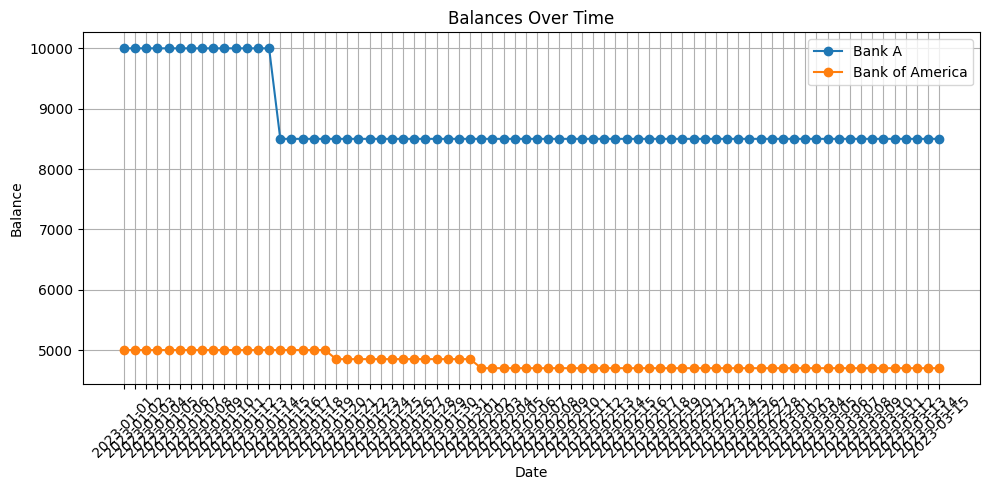

In [ ]:
start_date = '2023-01-01'
end_date = '2023-03-15'

ei_finance.get_expenses_per_bank()
plt.figure(figsize=(10, 5))
lines = []
for account, expenses in ei_finance.expenses_per_bank.items():
    idx = next((i for i, acc in enumerate(ei_finance.accounts) if acc.name == account), None)
    if idx is not None:
        ei_finance.accounts[idx].calculate_balance(end_date, expenses)
        all_dates = ei_finance.accounts[idx].diff(start_date, end_date)
        dates = [d for d in all_dates if d in ei_finance.accounts[idx].balance]
        if not dates:
            continue
        balances = [ei_finance.accounts[idx].balance[d] for d in dates]
        line, = plt.plot(dates, balances, marker='o', label=account)
        lines.append(line)
plt.title('Balances Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
